1. Install and Import Libraries

In [11]:
#!pip install torch torchvision matplotlib tqdm

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from torch.autograd import Variable


 2. Set Hyperparameters

In [5]:
n_epochs = 5
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
latent_dim = 100
img_size = 64
channels = 3
sample_interval = 500

img_shape = (channels, img_size, img_size)
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

3. Define Generator

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

4. Define Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

5. Prepare Dataset

In [8]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

celeba_dataset = ImageFolder(
    root="/home/cyber1/Documents/GitHub/PyTorch-GAN/implementations/gan/data/celeba/train",
    transform=transform
)

dataloader = DataLoader(
    celeba_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4
)

6. Initialize Models/Optimizers 

In [9]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
adversarial_loss = nn.BCELoss().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))


7. Image Display Function

In [12]:
def show_images(images, nrow=5):
    grid = make_grid(images, nrow=nrow, normalize=True)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(grid.cpu(), (1,2,0)))
    plt.axis('off')
    plt.show()

8. Training Loop with Real Time Output

[Epoch 4/5] [Batch 3000/3166] [D loss: 0.5733] [G loss: 0.8751]


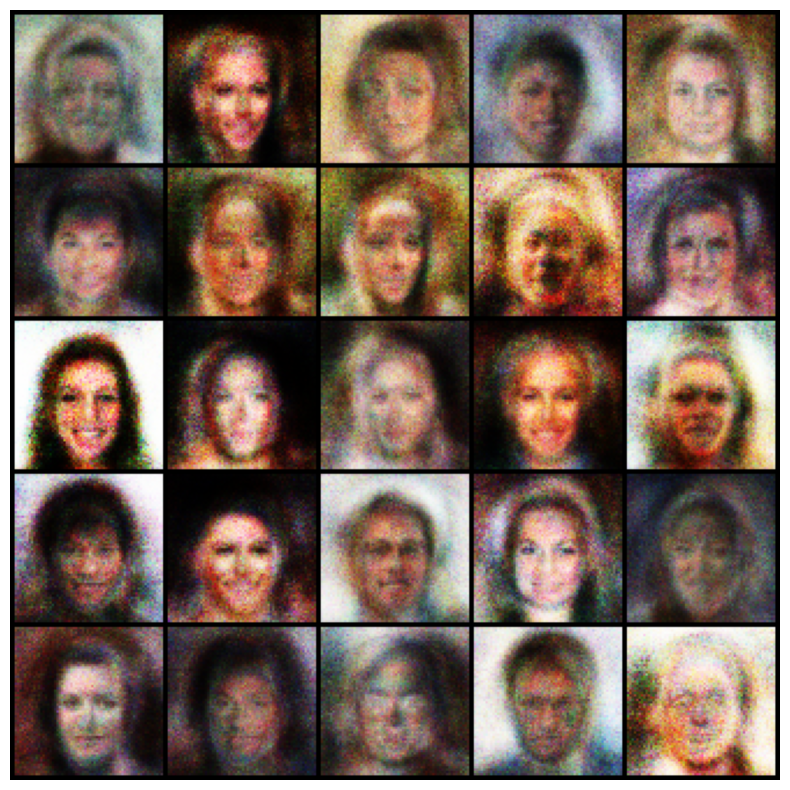

100%|██████████| 3166/3166 [00:45<00:00, 68.92it/s]


In [14]:
G_losses = []
D_losses = []

from IPython.display import clear_output

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(dataloader)):
        
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        real_imgs = imgs.to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % sample_interval == 0:
            clear_output(wait=True)
            print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
            show_images(gen_imgs[:25])


9. Loss Plot Post Training

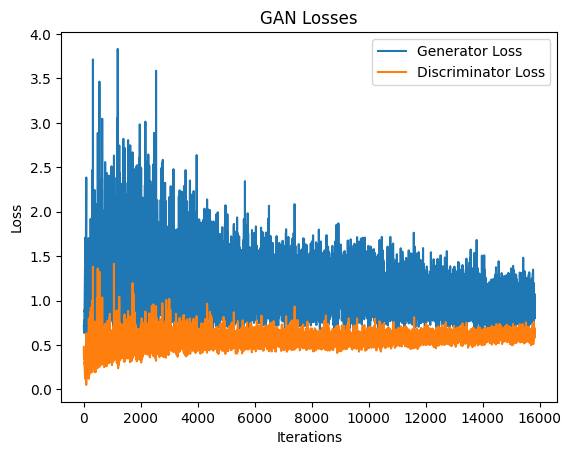

In [15]:
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("GAN Losses")
plt.show()


10. Generation of New Faces

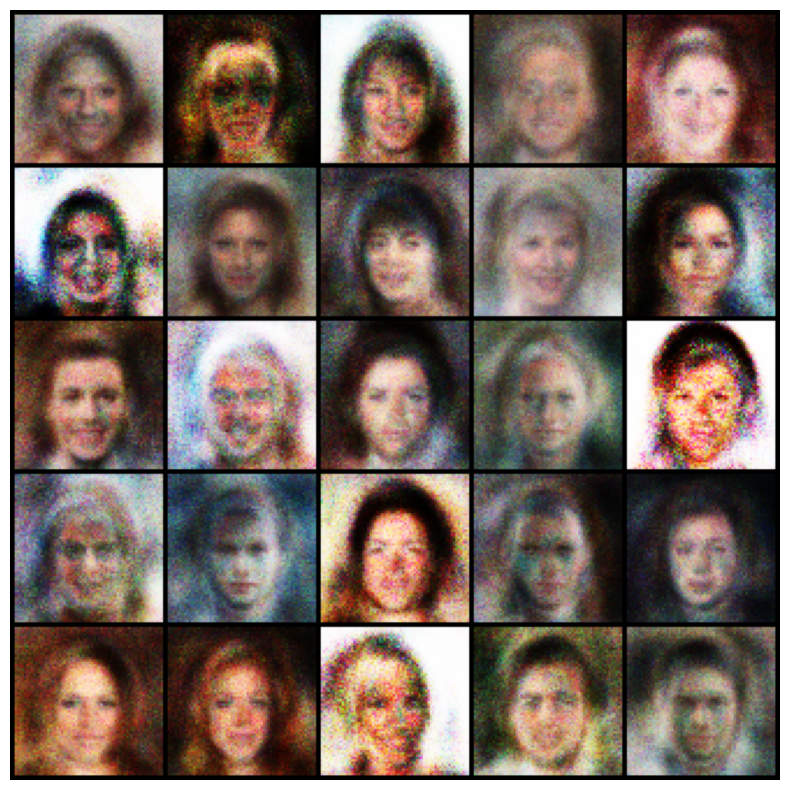

In [20]:
z = torch.randn(25, latent_dim, device=device)
gen_imgs = generator(z)
show_images(gen_imgs, nrow=5)


11. Additional Comparison

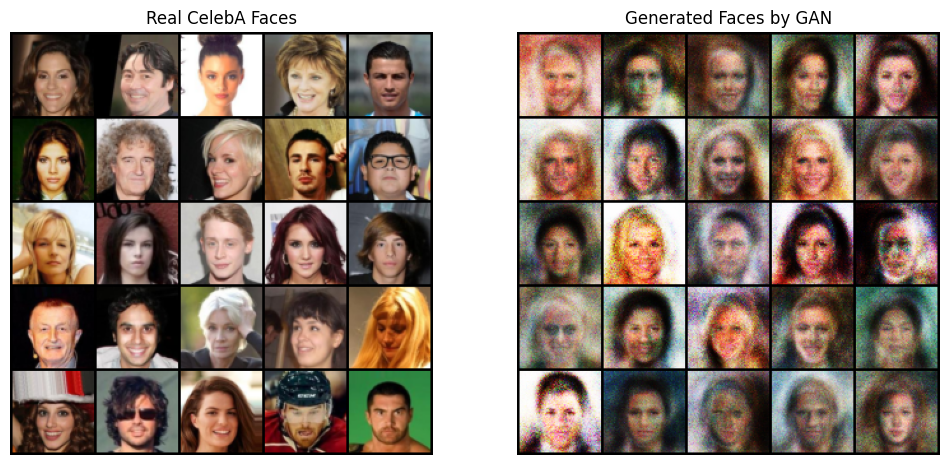

In [24]:
real_imgs, _ = next(iter(dataloader))

z = torch.randn(real_imgs.size(0), latent_dim).to(device)
gen_imgs = generator(z)

def denormalize(tensor):
    return tensor * .5 + .5

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Denormalize images for visualization
real_imgs = denormalize(real_imgs)
gen_imgs = denormalize(gen_imgs)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Real images
axs[0].imshow(make_grid(real_imgs[:25], nrow=5).permute(1, 2, 0).cpu())
axs[0].set_title('Real CelebA Faces')
axs[0].axis('off')

# Fake images
axs[1].imshow(make_grid(gen_imgs[:25], nrow=5).permute(1, 2, 0).detach().cpu())
axs[1].set_title('Generated Faces by GAN')
axs[1].axis('off')

plt.show()

